# PokeNet: Pokemon Image Classification with Deep Convolutional Neural Networks

In this notebook I provide a detailed account of my process building and training a deep convolutional neural network to classify images of Pokemon. The dataset I use contains 7000 images of 149 Pokemon, with roughly 47 images per class. This relatively high amount of classes and low amount of images proved to be a challenging problem to overcome. Using various techniques I was able to increase my initial validation accuracy of 50% to 90%, which given the nature of the data I believe to be a reasonably good result. 

The data used in this notebook can be found at: https://www.kaggle.com/lantian773030/pokemonclassification

## Imports

In [13]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import keras_preprocessing
from keras_preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.applications.mobilenet import preprocess_input
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.layers import Dense,GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import split_folders

## Data Preparation 

As the data is not pre-split into a train and validation/test set, doing so will be the first task. Fortunately split_folders makes this an incredibly simple exercise.  We will assign 80% of the data to a test set, and the remaining 20% to a validation set. Given the low amount of images per class, we do not define a test set. 

In [14]:
#split_folders.ratio("PokemonData", output="PokemonSplit", ratio=(0.8, 0.2))

As we read in the data, the pixel values of each image are rescaled to between 0-1. Rescaling inputs is done to reduce the range of values the models weights can occupy. It is essential to also rescale the size of every image to a common value  

In [15]:
training_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_gen = training_datagen.flow_from_directory('PokemonSplit/train',
                                                 target_size=(256,256),
                                                class_mode='categorical')

Found 5359 images belonging to 149 classes.


In [17]:
val_gen = validation_datagen.flow_from_directory('PokemonSplit/val',
                                                 target_size=(256,256),
                                                class_mode='categorical')

Found 1420 images belonging to 149 classes.


Here we define a list of our classes, and test that the labels are as expected.  We print the amount of images belonging to two particular classes, and preview 8 images of each.

In [18]:
classes = os.listdir('PokemonData')
classes[101]

'Pikachu'

In [19]:
train_gengar_dir = 'PokemonSplit/train/Gengar'

num_gengar_train = len(os.listdir(train_gengar_dir))
print("Total Gengar training images: ", num_gengar_train)

train_pikachu_dir = 'PokemonSplit/train/Pikachu'

num_pikachu_train = len(os.listdir(train_pikachu_dir))
print("Total Pikachu training images: ", num_pikachu_train)

Total Gengar training images:  39
Total Pikachu training images:  49


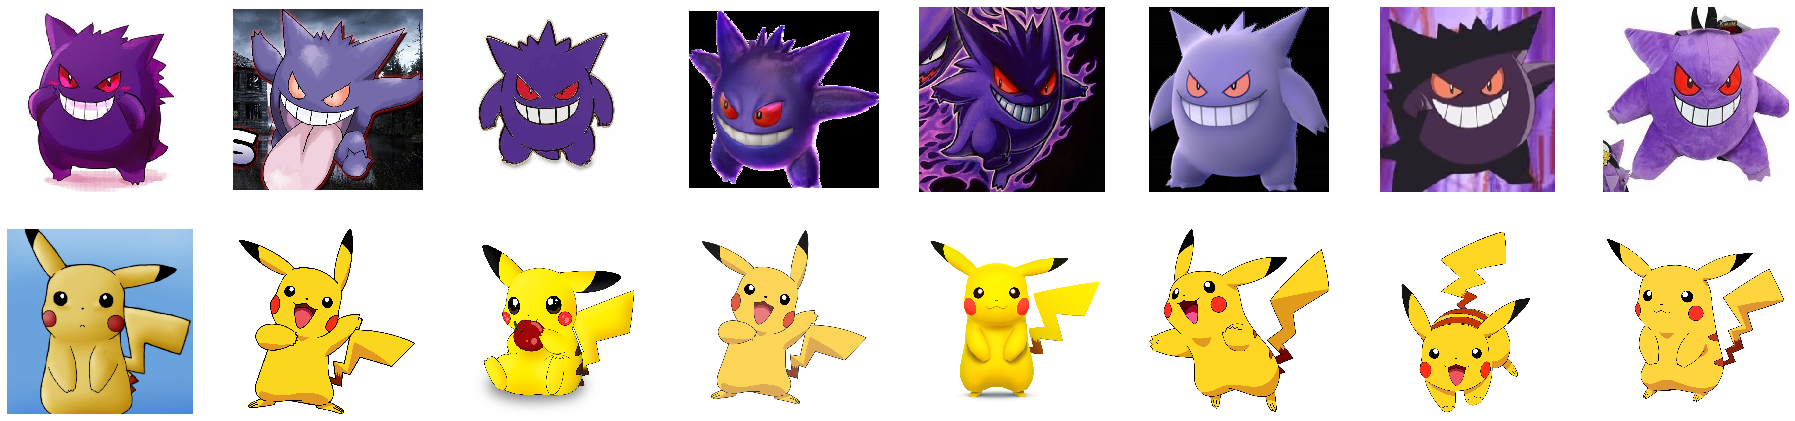

In [20]:
gengar_names = os.listdir(train_gengar_dir)
pikachu_names = os.listdir(train_pikachu_dir)

nrow = 8
ncol = 8

pic_index = 0 

fig = plt.gcf()
fig.set_size_inches(ncol*4, nrow*4)

pic_index += 8

gengar_pic = [os.path.join(train_gengar_dir, fname) for fname in gengar_names[pic_index-8:pic_index]]
pikachu_pic = [os.path.join(train_pikachu_dir, fname) for fname in pikachu_names[pic_index-8:pic_index]]

for i, img_path in enumerate(gengar_pic + pikachu_pic):
    sub = plt.subplot(nrow, ncol, i+1)
    sub.axis("Off") 
    
    img = plt.imread(img_path, 0)
    plt.imshow(img)

## Convolutional model

Here we define the architecture of the convolutional neural network. CNN’s work by reducing the amount of inputs by sliding filters over the input values to extract features. The values within these filters are the optimisable weights of the convolutional layers. Max pooling is performed after each convolutional layer. This operation condenses neighbouring values (activations) down to the single largest activation contained within that region. 

After another convolutional and max pooling layer, batch normalization is performed. This process is very similar to that of rescaling the initial pixel values to between 0-1. The effect of batch normalisation is to reduce the distribution of activations that is input to deeper layers, which decreases training time.

 After another convolutional and max pooling layer, the resulting tensor of activations are then unrolled into a one dimensional array.  Through a series of fully connected neural layers, the number of activations is reduced to the number of classes we are classifying, with an activation corresponding to each class. The class with the highest corresponding activation is the class predicted by the model for that particular image input. We regularize the model via dropout of one of these layers. This effectively turns off a random specified portion of neurons for each pass through the model. This forces the model to reduce the co-dependency between neurons that can lead to over-fitting. 
 
After defining its architecture we display a summary of the model.  


In [21]:
img_shape=(256,256,3)

model = tf.keras.Sequential(name='PokeNet')
model.add(tf.keras.layers.Conv2D(128,3,input_shape=(img_shape),activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(128,3,strides=(2,2),activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64,3,strides=(2,2),activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1024,activation='relu'))
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dense(len(classes),activation='softmax'))


model.summary()

Model: "PokeNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 128)     3584      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 63, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 128)       512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 64)        73792     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0   

We now compile the model and implement a callback feature. If during training the model surpasses a specified accuracy threshold, further training is aborted.  The model is then fit to the data and its training history stored. We can access this training history and plot the training and validation accuracy after each epoch. One epoch is a single pass of the entire dataset through the model. 

In [22]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.categorical_crossentropy,
             metrics=['accuracy']
             )


In [23]:
# implement callback function to terminate training once a validation accuracy of 90% is achieved.

validation_acc = 0.90

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get("val_accuracy") >= validation_acc):
            print('\nValidation threshold achieved. Aborting training.')
            self.model.stop_training=True
            
callbacks = myCallback()  

In [24]:
hist = model.fit_generator(train_gen, epochs=50, validation_data=val_gen, verbose=1, 
                           callbacks=[callbacks], workers=10)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 168 steps, validate for 45 steps
Epoch 1/50
168/168 [==============================] - 27s 160ms/step - loss: 4.5321 - accuracy: 0.0504 - val_loss: 4.6812 - val_accuracy: 0.0613
Epoch 2/50
168/168 [==============================] - 27s 161ms/step - loss: 3.0402 - accuracy: 0.2420 - val_loss: 3.3166 - val_accuracy: 0.1986
Epoch 3/50
168/168 [==============================] - 27s 163ms/step - loss: 2.1376 - accuracy: 0.4311 - val_loss: 2.2710 - val_accuracy: 0.4000
Epoch 4/50
168/168 [==============================] - 28s 169ms/step - loss: 1.5023 - accuracy: 0.5848 - val_loss: 2.2096 - val_accuracy: 0.4556
Epoch 5/50
168/168 [==============================] - 28s 168ms/step - loss: 1.0527 - accuracy: 0.6943 - val_loss: 2.3885 - val_accuracy: 0.4366
Epoch 6/50
168/168 [==============================] - 28s 167ms/step - loss: 0.7022 - accuracy: 0.7893 - val_loss: 2.1720 - val_accuracy: 0.4915
Epoch 7/50
168/168 [=================

## Results

Upon analysis of the training history it is evident the model is performing poorly. Although we achieve 97% accuracy classifying the training data, this is overshadowed by a 50% accuracy on the validation data. This large discrepancy in accuracies between data sets could be caused by a variety of factors. I first try experimenting with the model architecture and training time in an effort to gauge the degree to which the model is over-fitting the training data. I trained numerous new models, varying their depths and extent of regularisation. Unfortunately this had little effect on the validation accuracy.

As the amount of data for each class is very low (<50 images), I apply data augmentation when reading in the images with ImageDataGenerator. For each epoch, this applies different random transformations on the images to artificially increase the size of the training set. This had a positive effect, increasing the validation accuracy to 60%.

We plot nine examples each of predictions for training and testing set images.  


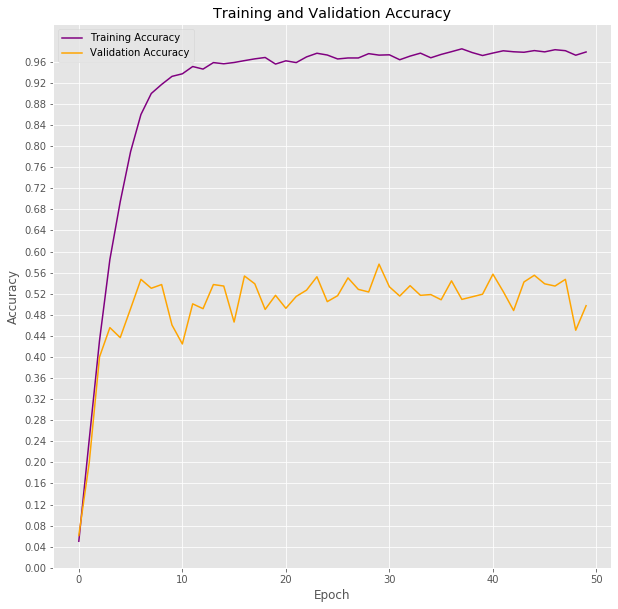

In [37]:
plt.style.use('ggplot')
plt.figure(figsize=(10,10))
plt.plot(hist.history['accuracy'],label='Training Accuracy',color='purple')
plt.plot(hist.history['val_accuracy'],label='Validation Accuracy',color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1, step=0.04))
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

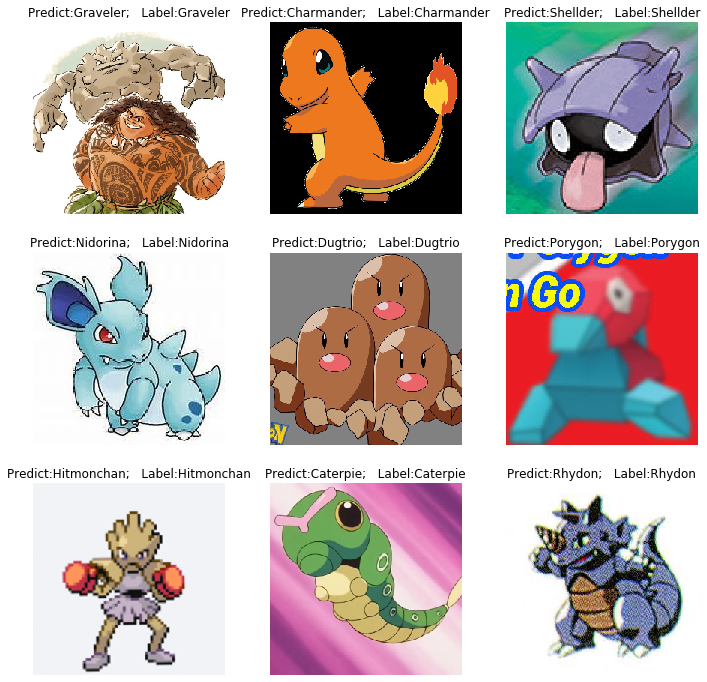

In [26]:
plt.figure(figsize=(12,12))

_x_,_y_ = next(train_gen) 
pred_ = model.predict(_x_)
for i in range(9):
    pred,y = pred_[i].argmax(), _y_[i].argmax()
    plt.subplot(3,3,i+1)
    plt.axis("Off") 
    plt.imshow(_x_[i])
    title_ = 'Predict:' + str(classes[pred])+ ';   Label:' + str(classes[y])
    plt.title(title_,size=12)    
plt.show()

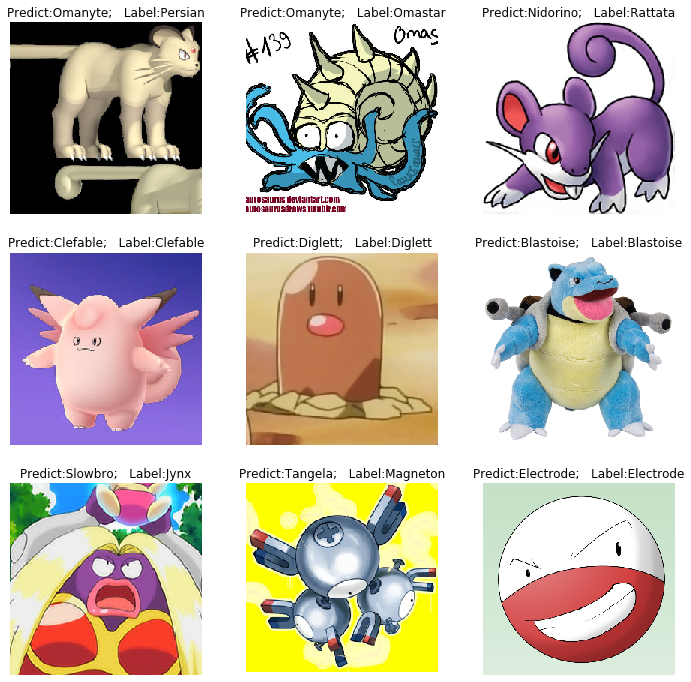

In [27]:
plt.figure(figsize=(12,12))

_x_,_y_ = next(val_gen) 
pred_ = model.predict(_x_)
for i in range(9):
    pred,y = pred_[i].argmax(), _y_[i].argmax()
    plt.subplot(3,3,i+1)
    plt.axis("Off") 
    plt.imshow(_x_[i])
    title_ = 'Predict:' + str(classes[pred])+ ';   Label:' + str(classes[y])
    plt.title(title_,size=12)    
plt.show()

## Transfer Learning

An incredibly powerful technique when working with small amounts of training data is to take advantage of larger pre-trained CNN’s. With transfer learning, you load in the model architecture and trained weights of a large CNN. These CNN’s are typically trained on millions of images and can accurately predict between more than 1000 classes. To apply a pre-trained CNN to your own objective, you remove the last layers of the pre-trained CNN and build your own in their place. Then when training this modified CNN on your own data, you freeze the pre-trained weights and only optimise the new layers.

Transfer learning works so well because the earlier layers in a CNN detect the simple features in an image, while the later layers detect more complex shapes and textures. Therefor by using these highly optimised early layers in your own CNN, your model can perform much better than if it had trained these generalised layers itself. The pre-trained model I use is MobileNet, a popular model used in transfer learning for image classification.
    
We import the pre-trained model, modify the final layers and display a model summary. This model is much deeper than the one we previously built and trained. We then load in the images, apply data augmentation, compile the model and train the final layers on the data.   


In [29]:
base_model=MobileNet(weights='imagenet',include_top=False) 

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) 
x=Dropout(0.25)(x)
x=Dense(1024,activation='relu')(x) 
x=Dense(512,activation='relu')(x) 
preds=Dense(149,activation='softmax')(x) 

C:\Users\blsco\Anaconda3\envs\deep\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [30]:
model=Model(inputs=base_model.input,outputs=preds, name='PokeNet')

for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [31]:
model.summary()

Model: "PokeNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [32]:
training_datagen2 = ImageDataGenerator(preprocessing_function=preprocess_input,
                                       rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

validation_datagen2 = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator=training_datagen2.flow_from_directory('PokemonSplit/train', 
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

valid_generator=validation_datagen2.flow_from_directory('PokemonSplit/val', 
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 5359 images belonging to 149 classes.
Found 1420 images belonging to 149 classes.


In [33]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.categorical_crossentropy,
             metrics=['accuracy']
             )

In [34]:
step_size_train=train_generator.n//train_generator.batch_size

hist2 = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=50, validation_data=valid_generator,
                           callbacks=[callbacks])

Epoch 1/50
167/167 [==============================] - 72s 429ms/step - loss: 4.0813 - accuracy: 0.1171 - val_loss: 7.1412 - val_accuracy: 0.0366
Epoch 2/50
167/167 [==============================] - 69s 413ms/step - loss: 2.3574 - accuracy: 0.3738 - val_loss: 4.2822 - val_accuracy: 0.2035
Epoch 3/50
167/167 [==============================] - 70s 420ms/step - loss: 1.5573 - accuracy: 0.5665 - val_loss: 3.5538 - val_accuracy: 0.3577
Epoch 4/50
167/167 [==============================] - 69s 414ms/step - loss: 1.2315 - accuracy: 0.6506 - val_loss: 2.1769 - val_accuracy: 0.5437
Epoch 5/50
167/167 [==============================] - 74s 443ms/step - loss: 0.9834 - accuracy: 0.7250 - val_loss: 1.4434 - val_accuracy: 0.4908
Epoch 6/50
167/167 [==============================] - 73s 438ms/step - loss: 0.8310 - accuracy: 0.7576 - val_loss: 1.3637 - val_accuracy: 0.7458
Epoch 7/50
167/167 [==============================] - 73s 435ms/step - loss: 0.7850 - accuracy: 0.7768 - val_loss: 0.6598 - val_ac

## Final Results

It is immediately obvious that this model has far surpassed the previous model in terms of validation accuracy. We are now managing to correctly classify validation images with 90% accuracy, which is almost double what we achieved with the original model. 

We conclude this notebook by saving the model and displaying some example predictions on the validation set. 


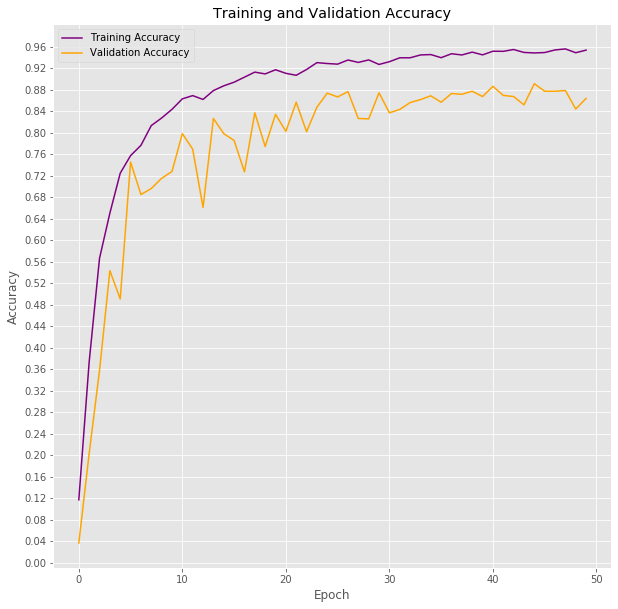

In [36]:
plt.style.use('ggplot')
plt.figure(figsize=(10,10))
plt.plot(hist2.history['accuracy'],label='Training Accuracy',color='purple')
plt.plot(hist2.history['val_accuracy'],label='Validation Accuracy',color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1, step=0.04))
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [46]:
model.save("PokeNet.h5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


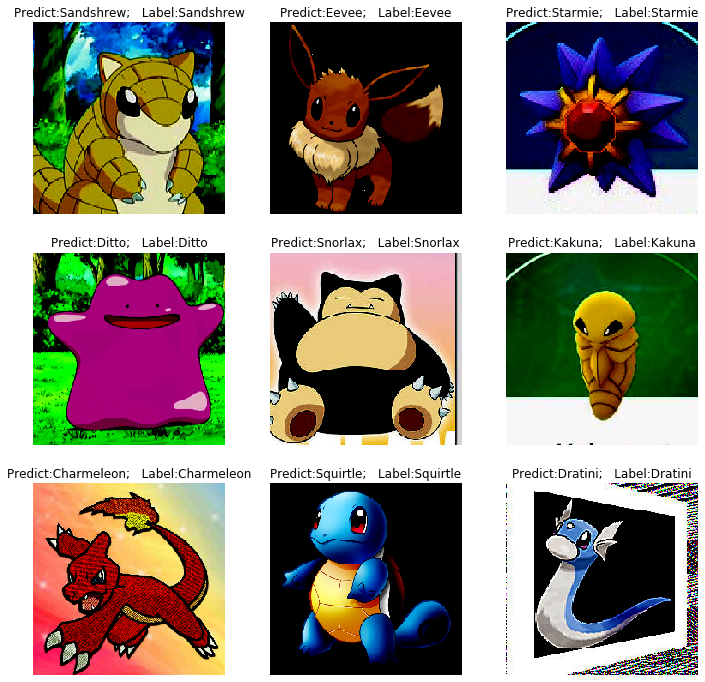

In [47]:
plt.figure(figsize=(12,12))

_x_,_y_ = next(valid_generator) 
pred_ = model.predict(_x_)
for i in range(9):
    pred,y = pred_[i].argmax(), _y_[i].argmax()
    plt.subplot(3,3,i+1)
    plt.axis("Off") 
    plt.imshow(_x_[i])
    title_ = 'Predict:' + str(classes[pred])+ ';   Label:' + str(classes[y])
    plt.title(title_,size=12)    
plt.show();